# 1 - Packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# 2 - Convolutional Neural Network

First there is the implementation for all the helper functions for bulid the neural network, then we will marge all this together to make the full neural network model

### 2.1 Zero-Padding

In [6]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0, 0)), 'constant' )
    ### END CODE HERE ###
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


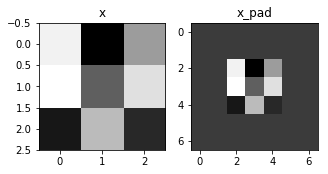

In [7]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### 2.2 Single step convolution

In [8]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Add bias.
    s = a_slice_prev * W + b
    # Sum over all entries of the volume s
    Z = np.sum(s)
    ### END CODE HERE ###

    return Z

In [9]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.1602122025


### 2.3  Convolutional Neural Networks - Forward pass
unvectorized version

In [26]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev - f + 2*pad)/stride) + 1
    n_W = int((n_W_prev - f + 2*pad)/stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                      # Select ith training example's padded activation
        for h in range(n_H):                            # loop over vertical axis of the output volume
            for w in range(n_W):                        # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = h + f
                    horiz_start = w
                    horiz_end = w + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[horiz_start:horiz_end, vert_start:vert_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [27]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.155859324889
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


# 3 - Pooling

### 3.1 Forward Pooling

In [28]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                            # loop over the training examples
        for h in range(n_H):                      # loop on the vertical axis of the output volume
            for w in range(n_W):                  # loop on the horizontal axis of the output volume
                for c in range (n_C):             # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h
                    vert_end = h+f
                    horiz_start = w
                    horiz_end = w+f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, horiz_start:horiz_end, vert_start:vert_end, c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.average(a_prev_slice)
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [29]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[ 1.74481176  1.6924546   2.10025514]]]


 [[[ 1.19891788  1.51981682  2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


# 4 - Backpropagation in convolutional neural networks

In [31]:
# we can do this calculation with computational library. so, don't make your brain hot if not needed :)
